

Pistes restantes a explorer :
 
1- réduire la classe majeure fait il gagner les performances ? ok

2- prendre en compte les splines 

3- interractions  ?

4- Outliers

Dataset dev :
- X_train : avec valeurs Nan , sans transformation (Hyperplot+300 -> 0.677)
- X_train_forest_imputed : Nan imputés avec Forest (Hyperplot+300 -> 0.673)
- X__Mice_imputed : Nan imputés avec Mice  (Hyperplot+300 -> 0.672)
- X_poly_2_No_nan : Nan imputés avec Forest + polynomes et interractions  (Hyperplot+300 -> 0.657)
- X_train_RandomUnderSampler , y_train_RandomUnderSampler : données parfaitement équilibrées mais moins importantes. (Hyperplot+300 -> 0.65) 
- X_train_del : imputation will bring a lot of noise (Hyperplot+300 -> 0.672, 1000 -> 0.673)
- X_train_poly2_outnan : polynomes sans OP100 (nan values) (Hyperplot+300 -> 0.657)


## I. Importing data

In [1]:
import pandas as pd
import numpy as np
data_x = pd.read_csv('traininginputs.csv')
data_y = pd.read_csv('trainingoutput.csv')

## II. Cleaning  & preparing data

### 2.1 Joindre les données (X & Y)

Nous commencons par joindre nos données en un seul dataset pour cela on utilise la variable PROC_TRACEINFO.

In [2]:
data = pd.merge(data_x, data_y, on='PROC_TRACEINFO', how ='inner')

### 2.2 Vérification doublons

Vérifions si des doublons se cachent dans le dataset

In [3]:
data['PROC_TRACEINFO'].duplicated().sum()

0

In [4]:
# Détecter les doublons en fonction de l ID des pieces dans la colonne PROC_TRACEINFO
duplicates = data[data['PROC_TRACEINFO'].duplicated()]
print(duplicates)

Empty DataFrame
Columns: [PROC_TRACEINFO, OP070_V_1_angle_value, OP090_SnapRingPeakForce_value, OP070_V_2_angle_value, OP120_Rodage_I_mesure_value, OP090_SnapRingFinalStroke_value, OP110_Vissage_M8_torque_value, OP100_Capuchon_insertion_mesure, OP120_Rodage_U_mesure_value, OP070_V_1_torque_value, OP090_StartLinePeakForce_value, OP110_Vissage_M8_angle_value, OP090_SnapRingMidPointForce_val, OP070_V_2_torque_value, Binar OP130_Resultat_Global_v]
Index: []


Il n y a pas de doublons.

### 2.3 Supression d'une variable inutile 

La variable PROC_TRACEINFO  s'avère etre inutile après la fusion des données car l'énnonce indique qu il s agit l ID des pieces : 

In [5]:
data = data.drop('PROC_TRACEINFO', axis =1 )

### 2.4 Data prep 

Nous explorant notre base de donnée afin de se faire une idée sur son contenu. Pour cela commencons par voir les dimensions de notre dataset (nombre d'observations et de variables):

In [6]:
nbr_lignes, nbr_colonnes = data.shape
print("Nbr de lignes :", nbr_lignes )
print("Nbr de colonnes :",nbr_colonnes )

Nbr de lignes : 34515
Nbr de colonnes : 14


Nous avons donc 14 variables pour 34.515 individus. 

Vérifions s'il y a des valeurs manquantes.

In [7]:
data.isna().sum()

OP070_V_1_angle_value                  0
OP090_SnapRingPeakForce_value          0
OP070_V_2_angle_value                  0
OP120_Rodage_I_mesure_value            0
OP090_SnapRingFinalStroke_value        0
OP110_Vissage_M8_torque_value          0
OP100_Capuchon_insertion_mesure    18627
OP120_Rodage_U_mesure_value            0
OP070_V_1_torque_value                 0
OP090_StartLinePeakForce_value         0
OP110_Vissage_M8_angle_value           0
OP090_SnapRingMidPointForce_val        0
OP070_V_2_torque_value                 0
Binar OP130_Resultat_Global_v          0
dtype: int64

Il semblerait que la variable 'OP100_Capuchon_insertion_mesure' compte 18.627 valeurs manquantes soit pour 53% des observations. Dans ce cas il serait difficile et pas pertinant de remplacer ces valeurs manquantes. 
Plusieurs options s'offrent  a nous : 
- Utiliser des modèles qui gèrent les valeurs manquantes de facon autonome
- Imputer des valeurs aux Nan en essayant plusieurs techniques 
- Supprimer la variable
- Supprimer les observations qui ont des valeurs manquantes'OP100_Capuchon_insertion_mesure' 

In [8]:
type_col = data.dtypes
print(type_col)

OP070_V_1_angle_value              float64
OP090_SnapRingPeakForce_value      float64
OP070_V_2_angle_value              float64
OP120_Rodage_I_mesure_value        float64
OP090_SnapRingFinalStroke_value    float64
OP110_Vissage_M8_torque_value      float64
OP100_Capuchon_insertion_mesure    float64
OP120_Rodage_U_mesure_value        float64
OP070_V_1_torque_value             float64
OP090_StartLinePeakForce_value     float64
OP110_Vissage_M8_angle_value       float64
OP090_SnapRingMidPointForce_val    float64
OP070_V_2_torque_value             float64
Binar OP130_Resultat_Global_v        int64
dtype: object


OK toutes les variables sont quantitatives. 
Par contre notre prédicteur (Binar OP130_Resultat_Global_v) devrait etre une variable catégorielle a deux modalités et non une variable continue. Nous procédons donc au changement de son type.

In [9]:
data['Binar OP130_Resultat_Global_v'] = data['Binar OP130_Resultat_Global_v'].astype('category')
print(data['Binar OP130_Resultat_Global_v'].dtype)

category


Diviser les données en train/test et définition des paramètres de la Validation croisée (essayer  StratifiedKFold ?)

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from scipy.stats import randint, uniform
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

L epreuve est un classement des participants en fonction des perfomances obtenues sur la fonction de perte (données entrainement). Afin que nos résultats puissent etre comparables avec les performances affichés, il conviendra de ne pas séparer nos données en train/test. Les performances du modèles sur les données test sont sensées etre mesurées par Valeo.

In [11]:
X_train = data.drop('Binar OP130_Resultat_Global_v', axis =1)
y_train = data['Binar OP130_Resultat_Global_v']

In [12]:
num_colonnes = X_train.shape[1]
print("Le nombre de colonnes dans le dataset est :", num_colonnes)

Le nombre de colonnes dans le dataset est : 13


Les données sont déjà propres, il n'y a pas de nettoyage à faire la problématique rencontrée est celle d'une classification binaire supervisée fortement déséquilibrée


## III. Data analysis 

In [13]:
import matplotlib.pyplot as plt

### 3.1. Données entrées / features

L'analyse de donnée est un travail déterminant pour la bonne compréhension de nos données et permet parfois de mieux aiguiller le travail de modélisation. L'analyse de données permet d'étudier aussi bien la relation entre les différentes variables mais aussi de se faire une idée sur la population (exemple son homogénéité).

In [14]:
print(data.describe())

       OP070_V_1_angle_value  OP090_SnapRingPeakForce_value   
count           34515.000000                   34515.000000  \
mean              159.906922                     156.915055   
std                15.662650                      11.271492   
min               101.800000                       0.000000   
25%               148.700000                     149.210000   
50%               158.000000                     156.180000   
75%               169.300000                     164.380000   
max               198.300000                     196.920000   

       OP070_V_2_angle_value  OP120_Rodage_I_mesure_value   
count           34515.000000                 34515.000000  \
mean              159.618236                   113.350222   
std                15.091490                     3.528522   
min                82.000000                    99.990000   
25%               149.400000                   111.040000   
50%               158.700000                   113.160000   
75%  

Contenu de la présence de valeurs manquantes dans l une de nos varibles nous décidons de partir un XGboost directement en premier essai car il intégre la possibilité de gestion de valeurs manquantes.

### 3.2. Valeur cible

In [15]:
occurrences = data['Binar OP130_Resultat_Global_v'].value_counts()

# Calculer les pourcentages
pourcentages = occurrences * 100 / len(data['Binar OP130_Resultat_Global_v'])

# Concaténer les occurrences et les pourcentages dans un DataFrame
result = pd.concat([occurrences, pourcentages], axis=1)
result.columns = ['Occurrences', 'Pourcentage']

# Afficher le résultat
print(result)

                               Occurrences  Pourcentage
Binar OP130_Resultat_Global_v                          
0                                    34210    99.116326
1                                      305     0.883674


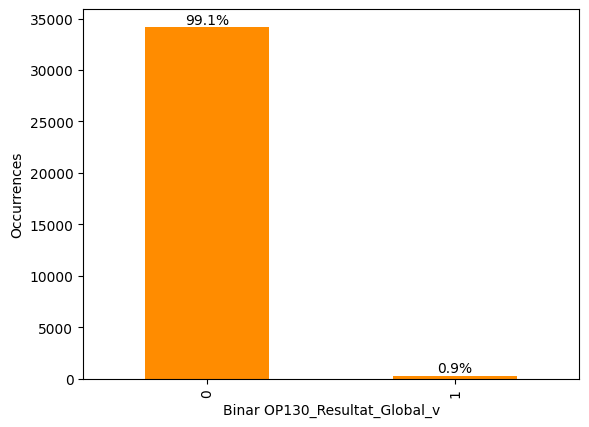

In [16]:
# Tracer le graphique à barres
fig, ax = plt.subplots()
occurrences.plot(kind='bar', color='darkorange', ax=ax)
ax.set_ylabel('Occurrences')

# Ajouter les pourcentages au-dessus des barres
for i, v in enumerate(pourcentages):
    ax.text(i, occurrences[i], f"{v:.1f}%", ha='center', va='bottom')

# Afficher le graphique
plt.show()

Prédicteur extremement déséquilibré.

### 3.3. PCA

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
data_nan0 = data.dropna( axis= 0).copy()

In [19]:
data_nan0.columns

Index(['OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP100_Capuchon_insertion_mesure', 'OP120_Rodage_U_mesure_value',
       'OP070_V_1_torque_value', 'OP090_StartLinePeakForce_value',
       'OP110_Vissage_M8_angle_value', 'OP090_SnapRingMidPointForce_val',
       'OP070_V_2_torque_value', 'Binar OP130_Resultat_Global_v'],
      dtype='object')

In [20]:
data_nan0 = data_nan0.drop('Binar OP130_Resultat_Global_v',axis= 1)

In [21]:
data_nan0

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value
1,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40
3,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61
6,158.8,153.91,152.5,111.25,12.11,12.19,0.38,11.97,6.41,18.79,17.7,81.56,6.40
11,168.9,150.21,152.0,114.40,12.12,12.14,0.40,11.97,6.41,17.88,15.2,77.85,6.44
15,159.4,147.90,123.3,110.67,12.11,12.26,0.38,11.97,6.41,19.14,13.9,83.96,6.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34503,149.0,160.08,168.0,110.15,11.81,12.22,0.35,11.97,6.61,27.01,21.3,99.50,6.61
34505,152.3,158.26,154.4,112.14,12.04,12.20,0.41,11.98,6.40,22.51,19.1,94.66,6.41
34506,137.2,146.88,144.5,113.92,12.12,12.23,0.38,11.97,6.41,17.87,16.4,81.78,6.41
34507,150.8,146.48,187.0,121.72,12.03,12.33,0.41,11.97,6.40,21.92,9.7,91.33,6.41


Résultats de PCA :
            PC1       PC2
0     -1.007804  0.386134
1      2.487252 -1.268797
2     -1.853071  1.271400
3     -2.299417  1.819549
4     -1.912555 -0.267720
...         ...       ...
15883  3.175646  0.628236
15884 -0.446060  0.311646
15885 -2.238378  0.406971
15886 -1.682918 -0.957600
15887 -1.369492 -0.678047

[15888 rows x 2 columns]


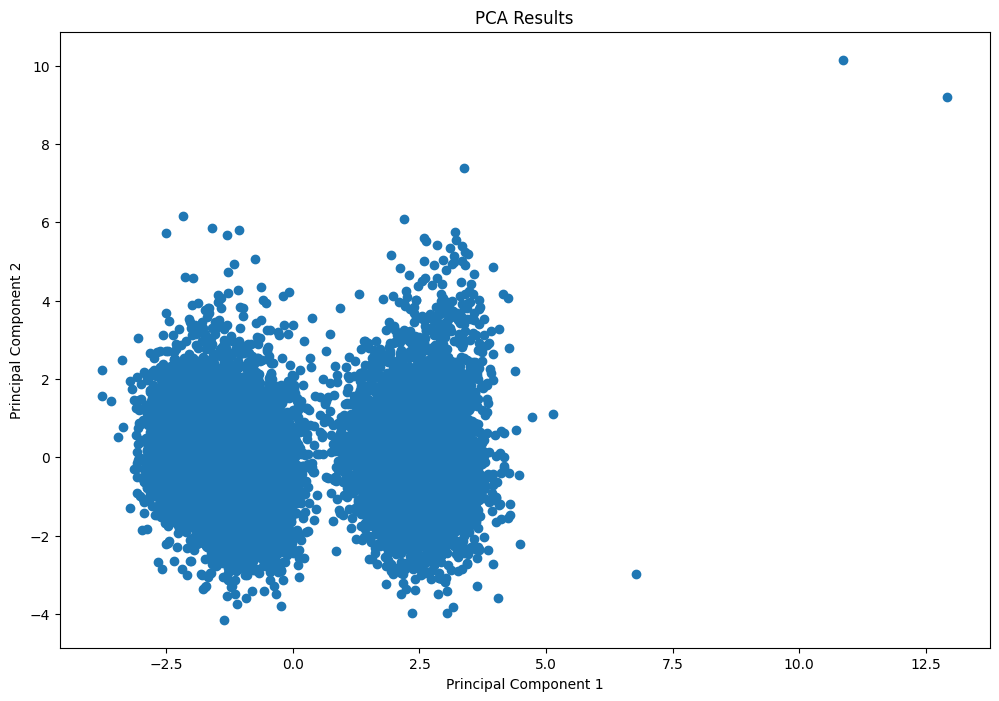

In [22]:
# Standardiser les données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_nan0) #data_nan0

# Effectuer PCA
pca = PCA(n_components=2)  # Spécifiez le nombre de composantes principales souhaitées
pca_result = pca.fit_transform(scaled_data)

# Créer un dataframe pour les résultats de PCA
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Afficher le dataframe de résultats de PCA
print("Résultats de PCA :")
print(pca_df)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [23]:
# Afficher les pourcentages de variance de tous les axes
explained_variances = pca.explained_variance_ratio_
print("Pourcentages de variance de tous les axes :")
for i, variance in enumerate(explained_variances):
    print(f"Composante {i + 1}: {variance:.2f}")

Pourcentages de variance de tous les axes :
Composante 1: 0.29
Composante 2: 0.11


Pourcentages d'inertie des trois premiers axes :
Composante 1: 0.29
Composante 2: 0.11
Composante 3: 0.10

Résultats de PCA :
            PC1       PC2       PC3
0     -1.007804  0.386134 -1.127008
1      2.487252 -1.268797 -0.088516
2     -1.853071  1.271400  0.929919
3     -2.299417  1.819549  0.807016
4     -1.912555 -0.267720  1.314139
...         ...       ...       ...
15883  3.175646  0.628236  0.153013
15884 -0.446060  0.311646 -0.502565
15885 -2.238378  0.406971  1.239672
15886 -1.682918 -0.957600 -0.118357
15887 -1.369492 -0.678047 -0.407303

[15888 rows x 3 columns]


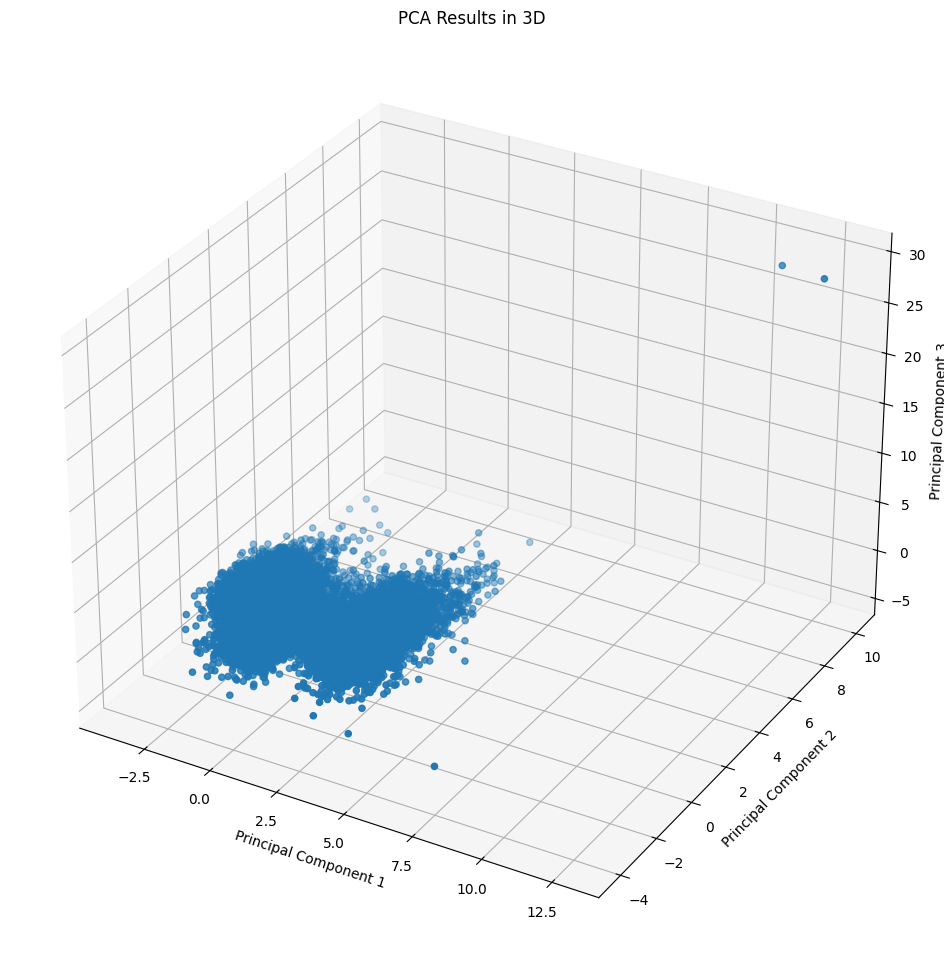

In [24]:
pca = PCA(n_components=3)  # Sélection des trois premiers axes
pca_result = pca.fit_transform(scaled_data)

# Pourcentages d'inertie des trois premiers axes
explained_variances = pca.explained_variance_ratio_
print("Pourcentages d'inertie des trois premiers axes :")
for i, variance in enumerate(explained_variances):
    print(f"Composante {i + 1}: {variance:.2f}")

# Créer un dataframe pour les résultats de PCA
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Afficher le dataframe de résultats de PCA
print("\nRésultats de PCA :")
print(pca_df)

# Visualiser les résultats en 3D
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Results in 3D')
plt.show()

Il pourrait etre interessant d'étudier les valeurs abérrantes.

### 3.3 Valeurs abérrantes

1- Méthode des z-scores
2- Méthode d'interquartile range (IQR) 
3- Algorithme de clustering


In [25]:
from scipy import stats

### 3.3 Numerical Features vs Target

In [26]:
import seaborn as sns

Nous essayerons de trouver la moyenne et la distribution des caractéristiques numériques pour les pièces défectueuses ou non.

In [27]:
data.columns

Index(['OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP100_Capuchon_insertion_mesure', 'OP120_Rodage_U_mesure_value',
       'OP070_V_1_torque_value', 'OP090_StartLinePeakForce_value',
       'OP110_Vissage_M8_angle_value', 'OP090_SnapRingMidPointForce_val',
       'OP070_V_2_torque_value', 'Binar OP130_Resultat_Global_v'],
      dtype='object')

In [28]:
# Diviser le DataFrame en fonction de la variable réponse
grouped = data.groupby('Binar OP130_Resultat_Global_v')


In [29]:
# Calculer la moyenne et la distribution pour chaque groupe
means = grouped.median() #  distribution asymétrique + résister aux valeurs aberrantes on part sur la médiane pr mieux représenter la valeur centrale
stds = grouped.std()

In [30]:
medians = grouped.median()

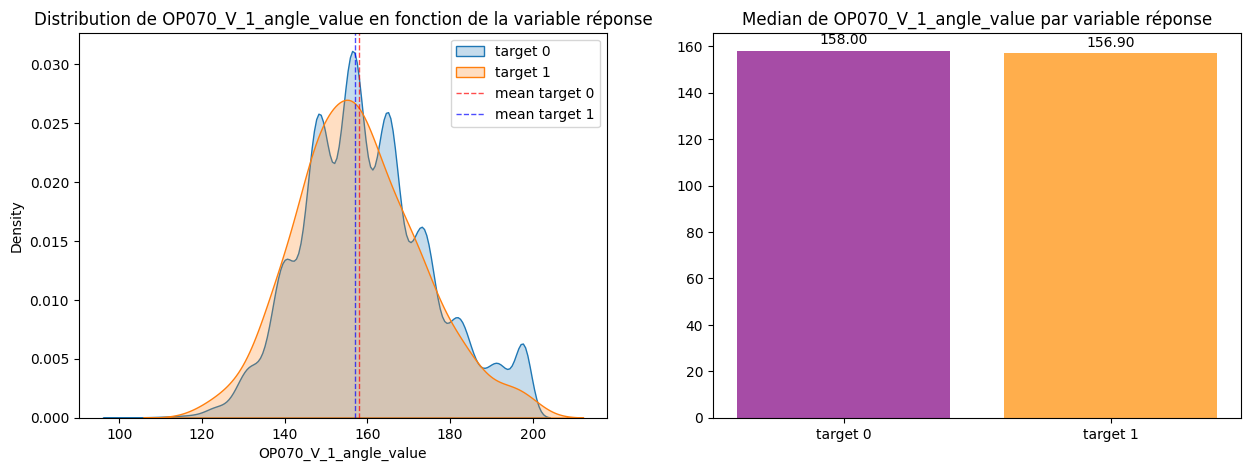

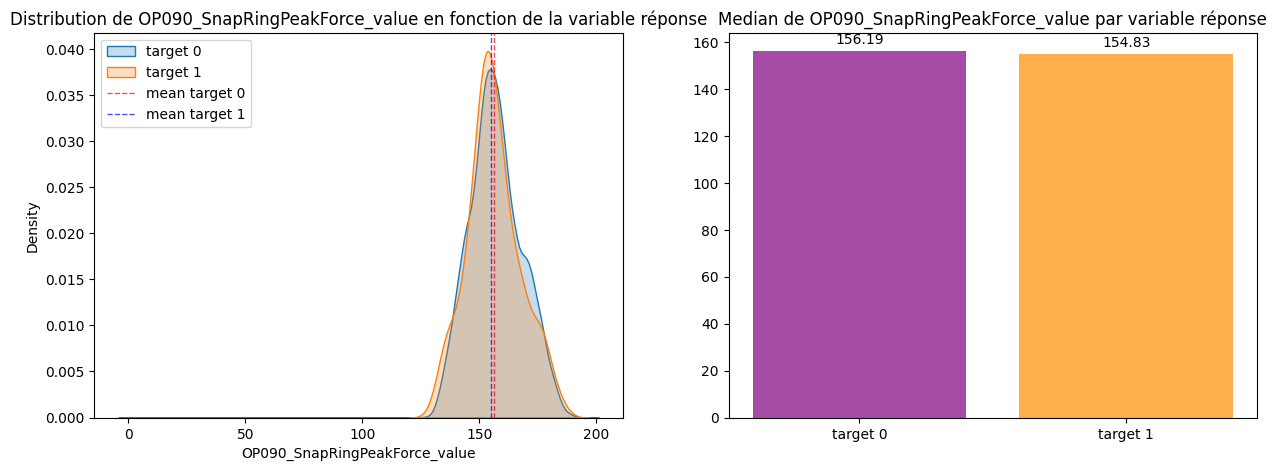

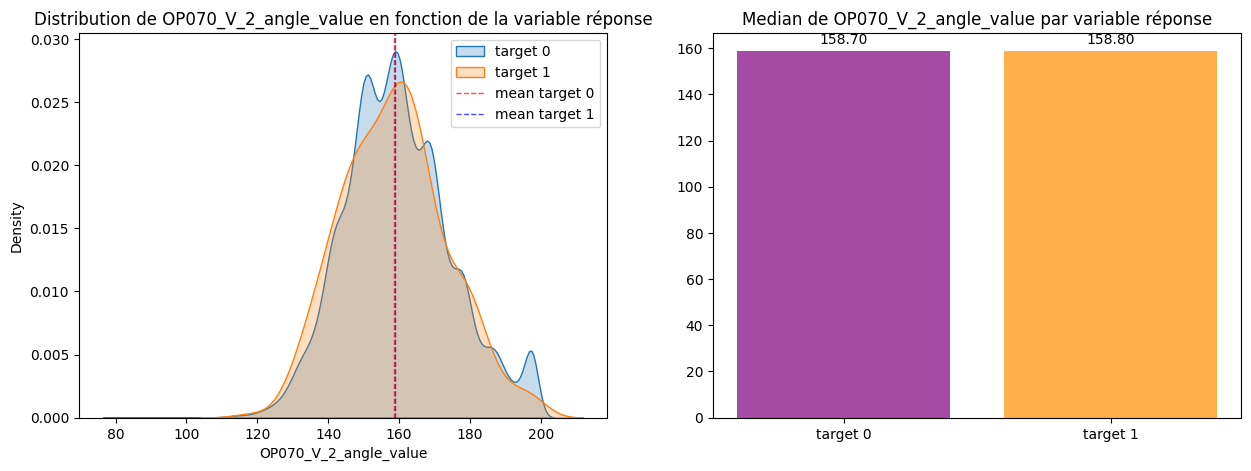

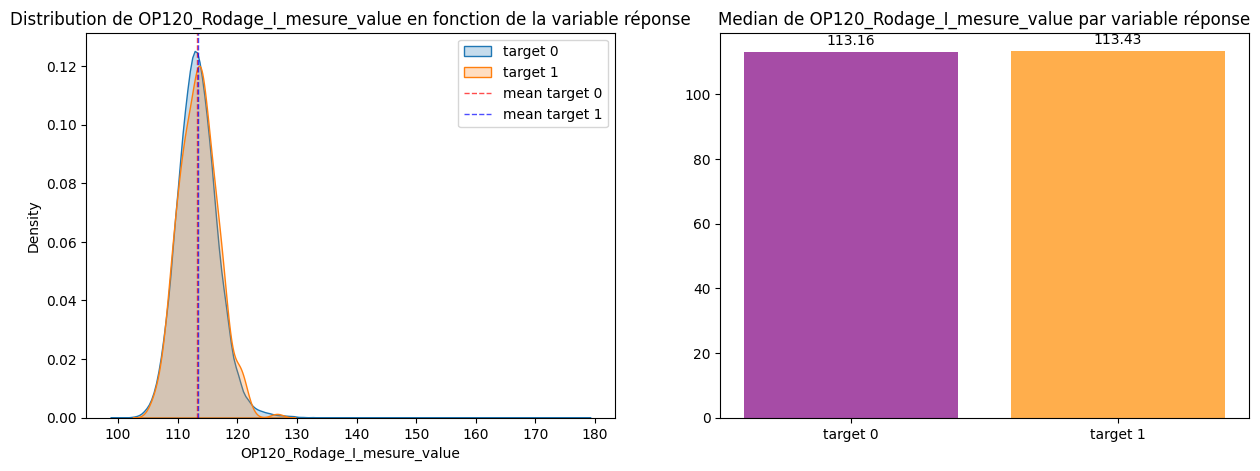

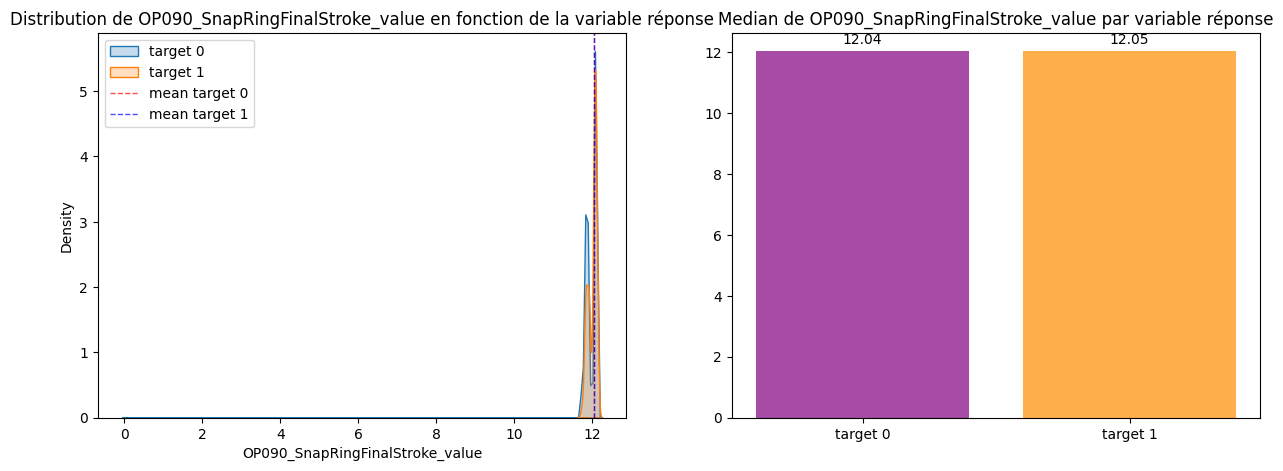

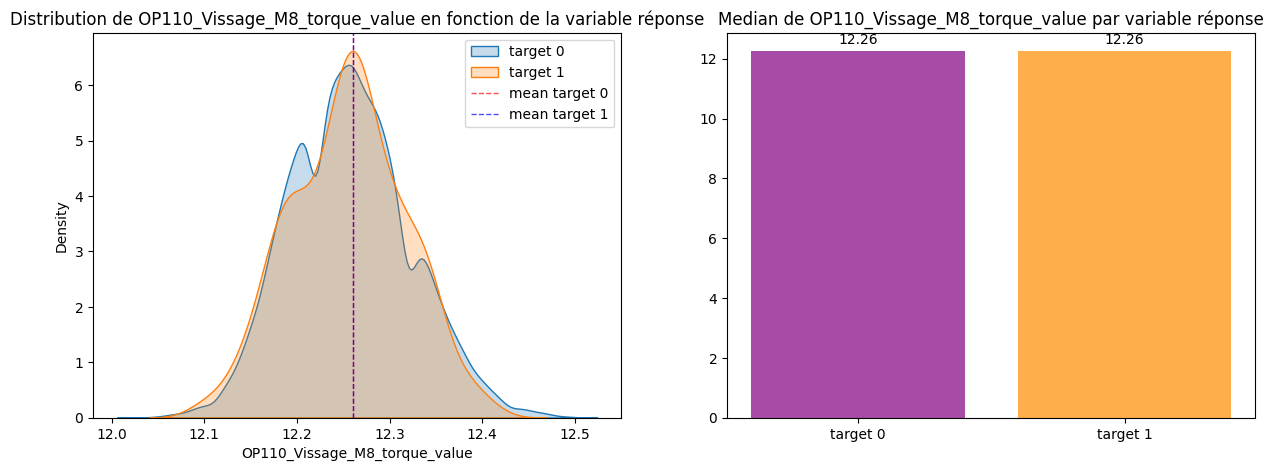

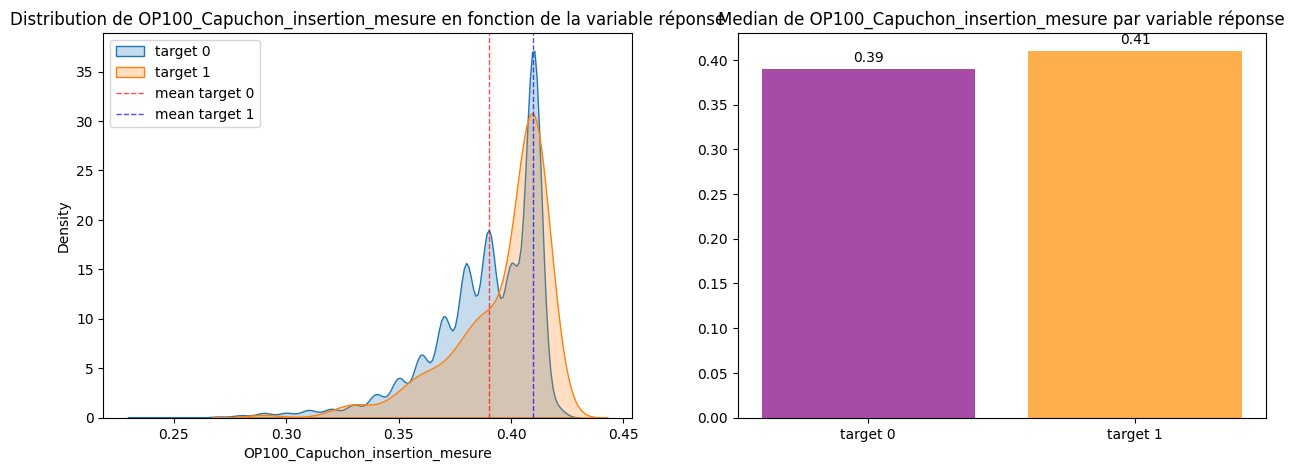

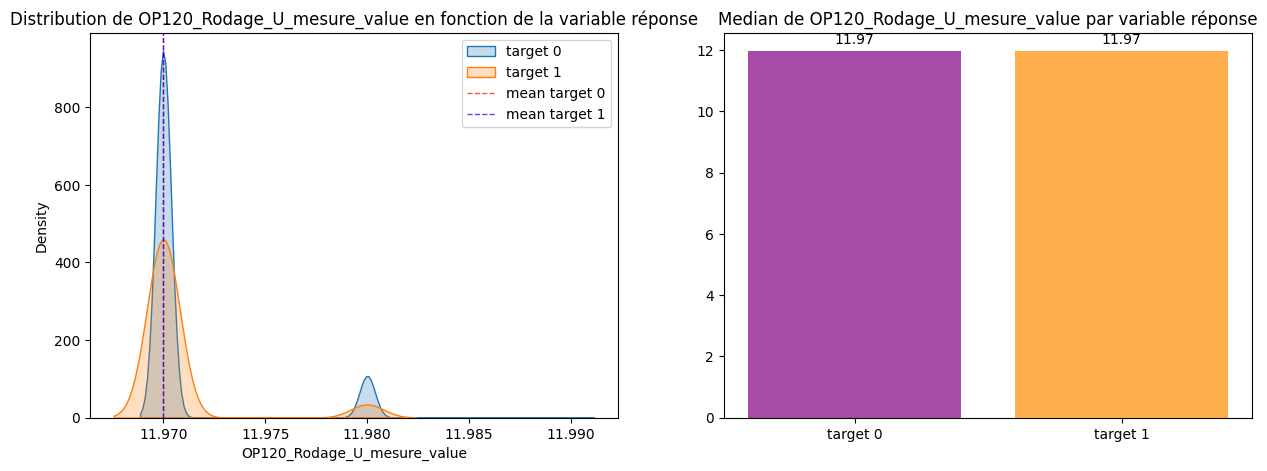

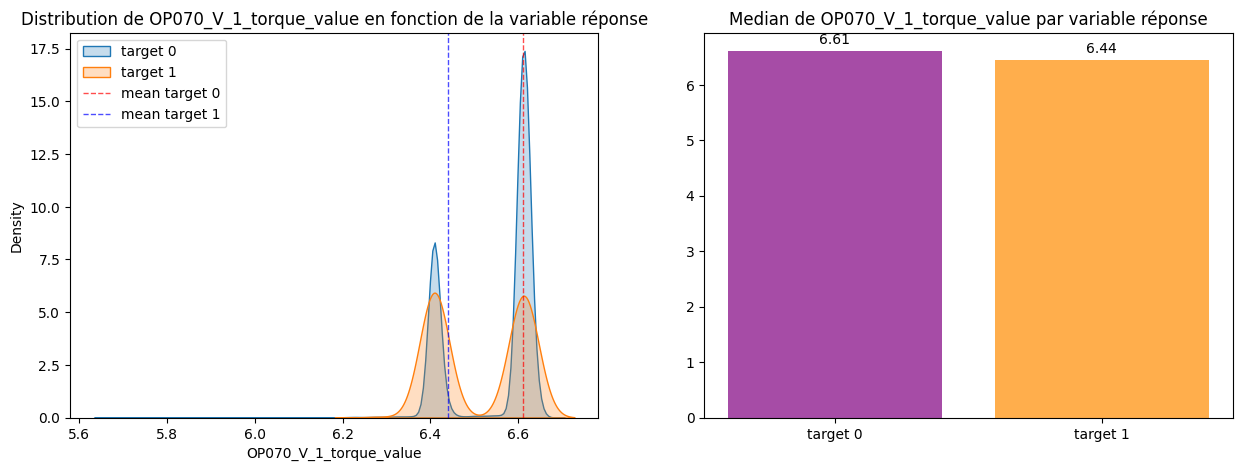

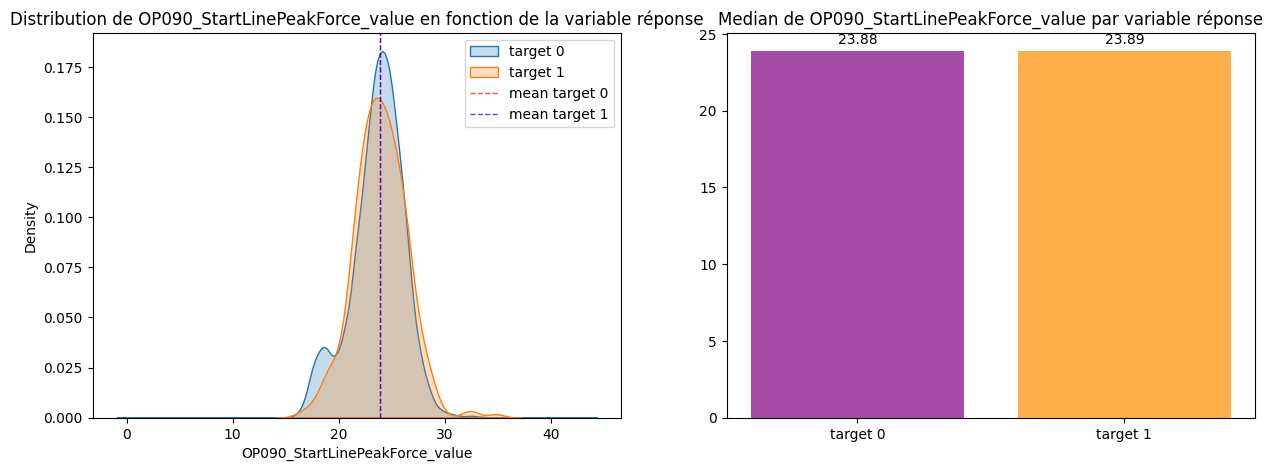

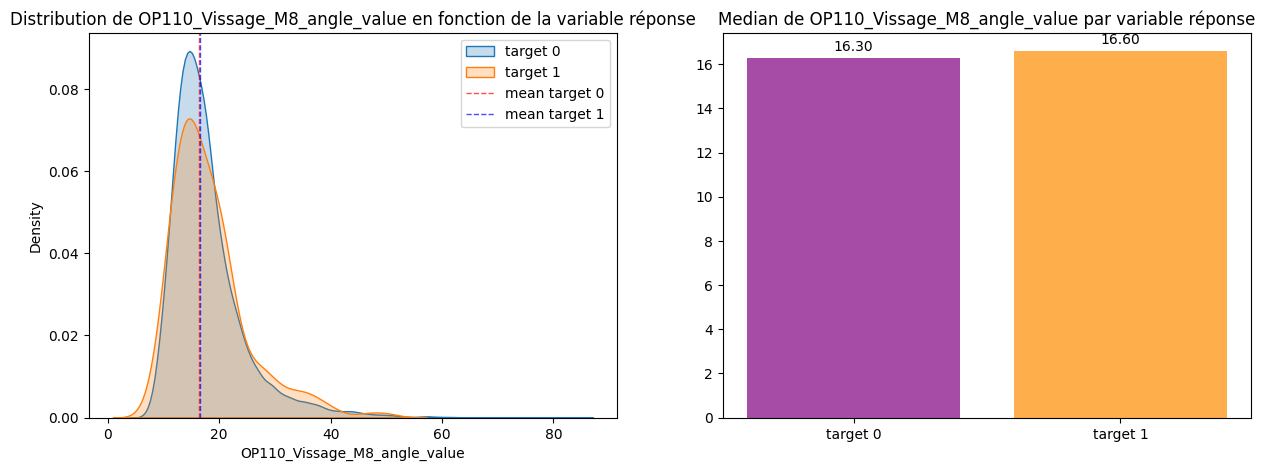

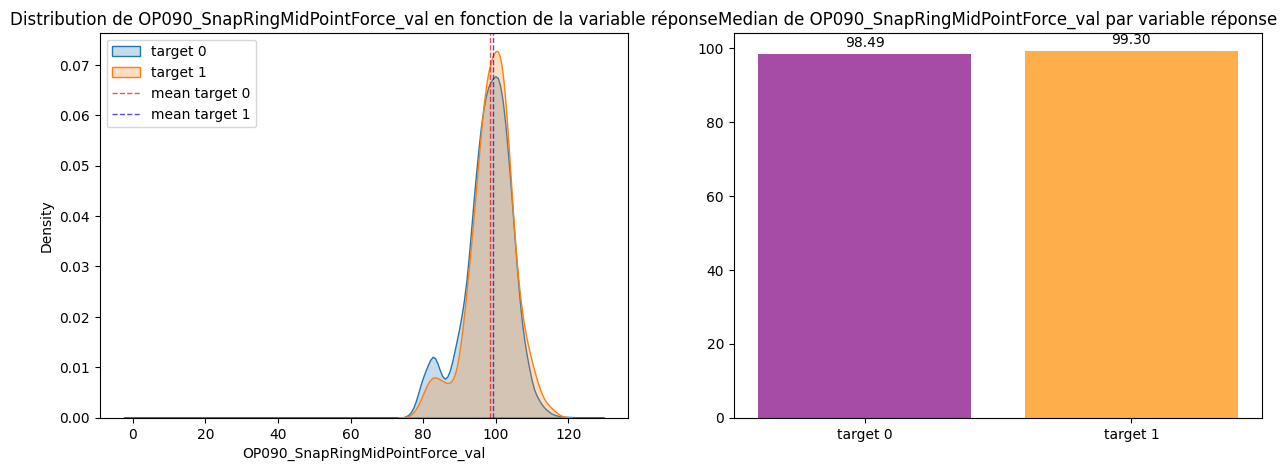

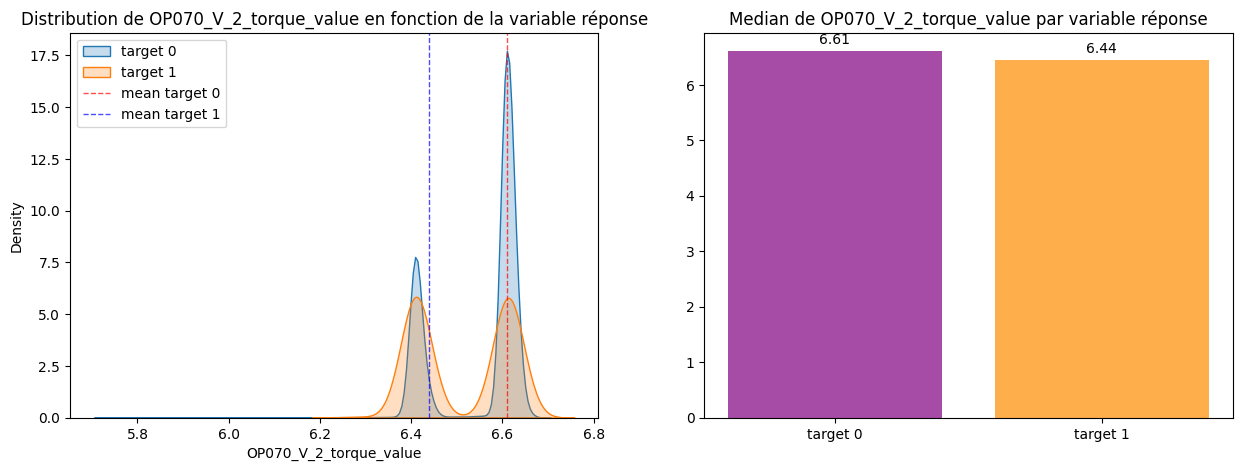

In [31]:
for col in data.columns[:-1]:  # Exclure la dernière colonne qui est la variable réponse
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for name, group in grouped:
        sns.kdeplot(group[col], label=f"target {name}", fill=True, ax=ax1)
    ax1.axvline(means[col][0], color='r', linestyle='dashed', linewidth=1, label='mean target 0', alpha=0.7)
    ax1.axvline(means[col][1], color='b', linestyle='dashed', linewidth=1, label='mean target 1', alpha=0.7)
    ax1.set_title(f'Distribution de {col} en fonction de la variable réponse')
    ax1.legend()

    bars = ax2.bar(['target 0', 'target 1'], [medians[col][0], medians[col][1]], color=['purple', 'darkorange'], alpha=0.7)
    ax2.set_title(f'Median de {col} par variable réponse')
    for bar, val in zip(bars, [medians[col][0], medians[col][1]]):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='white')
        ax2.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                     textcoords="offset points", ha='center', va='bottom')
    plt.show()

## IV. Feature engineering 


### 4.1 Equilibrage du prédicteur

La fonction RandomUnderSampler fait partie des techniques de rééchantillonnage utilisées en apprentissage automatique pour équilibrer les ensembles de données déséquilibrés, où une classe est fortement représentée par rapport aux autres en réduisant la sur-représentation d'une classe majoritaire en sous-échantillonnant aléatoirement la classe majoritaire afin de l'équilibrer avec la classe minoritaire.


In [32]:
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt

In [33]:
# Créez une instance de RandomUnderSampler - déséchantillonnage
rus = RandomUnderSampler(sampling_strategy='auto', random_state=1) # stratégie de sous-échantillonnage auto
X_train_RandomUnderSampler, y_train_RandomUnderSampler = rus.fit_resample(X_train, y_train)

In [34]:
type(y_train_RandomUnderSampler)

pandas.core.series.Series

In [35]:
y_train_RandomUnderSampler.value_counts()

Binar OP130_Resultat_Global_v
0    305
1    305
Name: count, dtype: int64

In [36]:
#RandomUnderSampler dataframe description
print("- RandomUnderSampler dataframe description :")

print("shape of X_train :", X_train.shape)
print("shape of X_train_RandomUnderSampler :", X_train_RandomUnderSampler.shape)
print("shape of Y_train_RandomUnderSampler :", y_train_RandomUnderSampler.shape)

# Nouvelle répartition des classes (y)
print("\n- NA Nouvelle répartition des classes :")
print(y_train_RandomUnderSampler.value_counts())

# NA in X_train_RandomUnderSampler
print("\n- NA in X_train_RandomUnderSampler :")
X_train_RandomUnderSampler.isna().sum()


- RandomUnderSampler dataframe description :
shape of X_train : (34515, 13)
shape of X_train_RandomUnderSampler : (610, 13)
shape of Y_train_RandomUnderSampler : (610,)

- NA Nouvelle répartition des classes :
Binar OP130_Resultat_Global_v
0    305
1    305
Name: count, dtype: int64

- NA in X_train_RandomUnderSampler :


OP070_V_1_angle_value                0
OP090_SnapRingPeakForce_value        0
OP070_V_2_angle_value                0
OP120_Rodage_I_mesure_value          0
OP090_SnapRingFinalStroke_value      0
OP110_Vissage_M8_torque_value        0
OP100_Capuchon_insertion_mesure    286
OP120_Rodage_U_mesure_value          0
OP070_V_1_torque_value               0
OP090_StartLinePeakForce_value       0
OP110_Vissage_M8_angle_value         0
OP090_SnapRingMidPointForce_val      0
OP070_V_2_torque_value               0
dtype: int64

### 4.2 Gestion des données manquantes 

Dans le cas d'une variable avec 50% de valeurs manquantes, il est important de choisir une méthode d'imputation qui soit capable de préserver les informations contenues dans les données. Les méthodes d'imputation plus sophistiquées, telles que KNN Imputation, MICE Imputation ou MissForest, peuvent être une bonne option dans ce cas : 
- MICE Imputation** : Cette méthode impute les valeurs manquantes en utilisant un modèle de mélange de variables latentes.
- MissForest** : Cette méthode impute les valeurs manquantes en utilisant une méthode d'apprentissage automatique basée sur les forêts aléatoires.

#### 4.1.1 MissForest imputation

In [37]:
import pandas as pd
from missforest.missforest import MissForest
import ipywidgets as widgets
from IPython.display import display

In [38]:
X_train_forest_imputed = X_train.copy()

In [40]:
# Imputation avec MissForest
imputer = MissForest(max_iter=50)
imputer.fit_transform(X_train_forest_imputed)

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value
0,180.4,190.51,173.1,113.64,12.04,12.16,0.39,11.97,6.62,26.37,18.8,109.62,6.60
1,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40
2,180.9,150.87,181.2,109.79,11.86,12.24,0.39,11.97,6.62,25.81,17.5,100.03,6.61
3,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61
4,174.5,172.29,177.5,112.88,12.07,12.19,0.39,11.97,6.62,29.22,33.6,99.19,6.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34510,158.2,168.40,180.6,110.65,11.88,12.23,0.39,11.98,6.61,24.03,14.8,98.76,6.61
34511,139.4,146.24,154.5,108.14,12.04,12.27,0.41,11.97,6.41,21.52,15.5,98.37,6.40
34512,165.5,157.34,149.8,112.77,12.09,12.17,0.39,11.97,6.62,22.65,24.4,92.92,6.62
34513,152.4,165.07,140.0,111.19,12.06,12.34,0.39,11.97,6.60,20.77,13.6,101.21,6.60


In [41]:
print(X_train_forest_imputed.isna().sum())
print(X_train_forest_imputed['OP100_Capuchon_insertion_mesure'])

#print("Shape X train after impute:", X_train_forest_imputed.shape, type(X_train_forest_imputed))

OP070_V_1_angle_value              0
OP090_SnapRingPeakForce_value      0
OP070_V_2_angle_value              0
OP120_Rodage_I_mesure_value        0
OP090_SnapRingFinalStroke_value    0
OP110_Vissage_M8_torque_value      0
OP100_Capuchon_insertion_mesure    0
OP120_Rodage_U_mesure_value        0
OP070_V_1_torque_value             0
OP090_StartLinePeakForce_value     0
OP110_Vissage_M8_angle_value       0
OP090_SnapRingMidPointForce_val    0
OP070_V_2_torque_value             0
dtype: int64
0        0.39
1        0.39
2        0.39
3        0.39
4        0.39
         ... 
34510    0.39
34511    0.41
34512    0.39
34513    0.39
34514    0.39
Name: OP100_Capuchon_insertion_mesure, Length: 34515, dtype: float64


In [42]:
print(type(X_train_forest_imputed))
#ok format

<class 'pandas.core.frame.DataFrame'>


#### 4.1.2 MICE Imputation

In [43]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [44]:
X__Mice_imputed = X_train.copy()

In [45]:
# Imputation avec MICE
mice_imputer = IterativeImputer(random_state=0)
X__Mice_imputed = mice_imputer.fit_transform(X__Mice_imputed)

In [46]:
print(type(X__Mice_imputed))
X__Mice_imputed = pd.DataFrame(X__Mice_imputed)
print(type(X__Mice_imputed))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [47]:
# Affichage des résultats
print("\nAprès imputation avec MICE :")
print(X__Mice_imputed.isna().sum())


Après imputation avec MICE :
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64


### 4.2 Deleting missing data OP100

In [48]:
X_train_del = X_train.copy()
X_train_del.columns

Index(['OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP100_Capuchon_insertion_mesure', 'OP120_Rodage_U_mesure_value',
       'OP070_V_1_torque_value', 'OP090_StartLinePeakForce_value',
       'OP110_Vissage_M8_angle_value', 'OP090_SnapRingMidPointForce_val',
       'OP070_V_2_torque_value'],
      dtype='object')

In [49]:
X_train_del = X_train_del.drop('OP100_Capuchon_insertion_mesure', axis = 1)
X_train_del.columns

Index(['OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP120_Rodage_U_mesure_value', 'OP070_V_1_torque_value',
       'OP090_StartLinePeakForce_value', 'OP110_Vissage_M8_angle_value',
       'OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value'],
      dtype='object')

### 4.3 Polynomial transformation (avec imputation)

La transformation polynomiale n'accepte pas de valeurs manquants. Il faudra donc utiliser les dataset avec valeurs manquantes imputées avec MissForest.

La fonction PolynomialFeatures effectue aussi les les intérractions entre les variables. A titre d'exemple un dataset avec deux variables nous donnera après transformation avec la fonction PolynomialFeatures au deuxieme degré 4 nouvelles colonnes ((n + d)! / d!n! features). Il faudra donc veiller au fléau de la dimension si nous décidons aller plus loin que le deuxieme degré.

In [50]:
from sklearn.preprocessing import PolynomialFeatures

In [51]:
poly_2 = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly_2_No_nan = poly_2.fit_transform(X_train_forest_imputed)

Transformation de np.array (format de sortie) a pandas DataFrame

In [52]:
print(type(X_poly_2_No_nan))
X_poly_2_No_nan = pd.DataFrame(X_poly_2_No_nan)
print(type(X_poly_2_No_nan))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [53]:
print ('Les dimensions du DF polynomial : ',X_poly_2_No_nan.shape)
print ('Les dimensions du DF Nan imputé avec MissForest : ',X_train_forest_imputed.shape)

Les dimensions du DF polynomial :  (34515, 104)
Les dimensions du DF Nan imputé avec MissForest :  (34515, 13)


In [54]:
X_train_forest_imputed.columns

Index(['OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP100_Capuchon_insertion_mesure', 'OP120_Rodage_U_mesure_value',
       'OP070_V_1_torque_value', 'OP090_StartLinePeakForce_value',
       'OP110_Vissage_M8_angle_value', 'OP090_SnapRingMidPointForce_val',
       'OP070_V_2_torque_value'],
      dtype='object')

### 4.3 Polynomial transformation (delete OP100 for Nan values)

In [55]:
X_train_poly2_outnan = X_train_del.copy()

In [56]:
X_train_poly2_outnan.isna().sum()

OP070_V_1_angle_value              0
OP090_SnapRingPeakForce_value      0
OP070_V_2_angle_value              0
OP120_Rodage_I_mesure_value        0
OP090_SnapRingFinalStroke_value    0
OP110_Vissage_M8_torque_value      0
OP120_Rodage_U_mesure_value        0
OP070_V_1_torque_value             0
OP090_StartLinePeakForce_value     0
OP110_Vissage_M8_angle_value       0
OP090_SnapRingMidPointForce_val    0
OP070_V_2_torque_value             0
dtype: int64

In [57]:
X_train_poly2_outnan = poly_2.fit_transform(X_train_poly2_outnan)

In [58]:
from scipy.interpolate import CubicSpline

In [59]:
# Création de splines pour certaines caractéristiques
#features_to_interpolate = ['OP100_Capuchon_insertion_mesure', 'OP070_V_2_angle_value']  # Remplacez les noms par vos propres fonctionnalités
#for feature in features_to_interpolate:
    #cs = CubicSpline(X_train.index, X_train[feature])
    #X_train[f'{feature}_spline'] = cs(data.index) 

In [60]:
X_train.columns

Index(['OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP100_Capuchon_insertion_mesure', 'OP120_Rodage_U_mesure_value',
       'OP070_V_1_torque_value', 'OP090_StartLinePeakForce_value',
       'OP110_Vissage_M8_angle_value', 'OP090_SnapRingMidPointForce_val',
       'OP070_V_2_torque_value'],
      dtype='object')

In [61]:
X_train_dropOP100 = X_train.drop('OP100_Capuchon_insertion_mesure' , axis =1)
X_train_dropOP100.columns

Index(['OP070_V_1_angle_value', 'OP090_SnapRingPeakForce_value',
       'OP070_V_2_angle_value', 'OP120_Rodage_I_mesure_value',
       'OP090_SnapRingFinalStroke_value', 'OP110_Vissage_M8_torque_value',
       'OP120_Rodage_U_mesure_value', 'OP070_V_1_torque_value',
       'OP090_StartLinePeakForce_value', 'OP110_Vissage_M8_angle_value',
       'OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value'],
      dtype='object')

# V. ML modeling

#### 2.1 Définition du modèle XG Boost

XGBoost, en tant qu'algorithme de boosting basé sur des arbres de décision, n'a  pas besoin de centrer ou de réduire les données en amont. Nous procédons donc au paramètrage de notre modèle. 
Comme évoqué précédemment, XGBoost est capable de gérer les valeurs manquantes automatiquement. Aucune configuration ne sera donc necessaire pour la gestion des valeurs manquantes.

In [62]:
model = xgb.XGBClassifier(
    n_jobs = -1, #utilise tous les coeurs CPU
    booster = 'gbtree',  # utilise les arbres de décision pour construire l'ensemble
    objective = 'binary:logistic', #classification a 2 classes (binaire)
    eval_metric = 'auc', 
    enable_categorical = True, 
    verbosity = 1 # printing messages , 0 (silent), 1 (warning), 2 (info), and 3 (debug). 
)

#### 2.2 Recherche d'hyperparamètres

Il existe deux types de paramètres en XGBoost : les paramètres intervenant lors du calcul du gain ou interet d ajouter un nouvel étage et donc infulancant la structure de l arbre  & ceux impactant le calcul du poids optimal a chaque feuille d abre impact donc directement les prédictions.

Attention la courbe roc est sensible a l'équilibre des classes ?! ce qui peut etre embetant lors de la recherche des hyperparamètres ( a développer)

##### Option 1: Recherche avec Grille (avec GridSearchCV) - Best_score 0.685


GridSearchCV effectue une recherche exhaustive à travers toutes les combinaisons possibles d'hyperparamètres spécifiées. Il parcourt chaque combinaison dans une grille prédéfinie, ce qui signifie qu'il teste toutes les valeurs d'hyperparamètres pour chaque hyperparamètre, ce qui peut être très coûteux en termes de calcul. Dans ce cas, nous nous contentons de selectionner aléatoirement quelques valeurs:  

In [64]:
# Spécifiez la grille des hyperparamètres à explorer
search_space_1 = {
    'learning_rate': [ 0.07 ,0.06], # fraction de la correction appliquée
    'n_estimators': [105, 100], # nombre d arbres a entrainer séquentiellement pour faire prédicteur final (biais /variance)
    'max_depth': [3, 4, 5], #profondeur maximale de ce que peut atteindre un arbre et donc des valeurs qu'il peut prendre soit 2^max_depth
    'min_child_weight': [ 1, 2, 3],
    'gamma': [ 0.2, 0.1], #définit le seuil du gain qu'apporte l'ajou de chaque nouveau noeud (0 -> pas de seuil)
    'subsample': [ 0.9, 1.0],
    'colsample_bytree': [0.8, 0.6, 0.7],
}

# Créez un objet GridSearchCV pour la recherche par grille
grid_search = GridSearchCV(model, 
                           search_space_1, 
                           scoring='roc_auc', 
                           cv=5, 
                           verbose=1, 
                           n_jobs=-1)

# Entraînez le modèle en utilisant la recherche par grille
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric='auc',
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.6, 0.7],
                         'gamma': [0.2, 0.1], 'learning_rate': [0.07, 0.06],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [105, 100], 'subsample': [0.9, 1.0]},
             scoring='roc_auc', verbose=1)

In [65]:
# Affichez les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Best score =", grid_search.best_score_)

Meilleurs hyperparamètres: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best score = 0.6854833453932079


Avec cette approche nous arrivons au score 0.685 ROC_AUC ce qui est suppérieur au score de 0.675 obtenu par Valéo en utilisant une   classification naïve bayésienne. 

Néanmoins, l'inconvénient de l'approche est biaisée par l'invention de l'humain. Le champs des paramètres possibles étant très large , le risque de tomber sur un 'minimal local' est donc très important.

In [66]:
best_model_GridSearchCV = grid_search.best_estimator_

In [67]:
feature_importance = best_model_GridSearchCV.feature_importances_
feature_names = X_train.columns

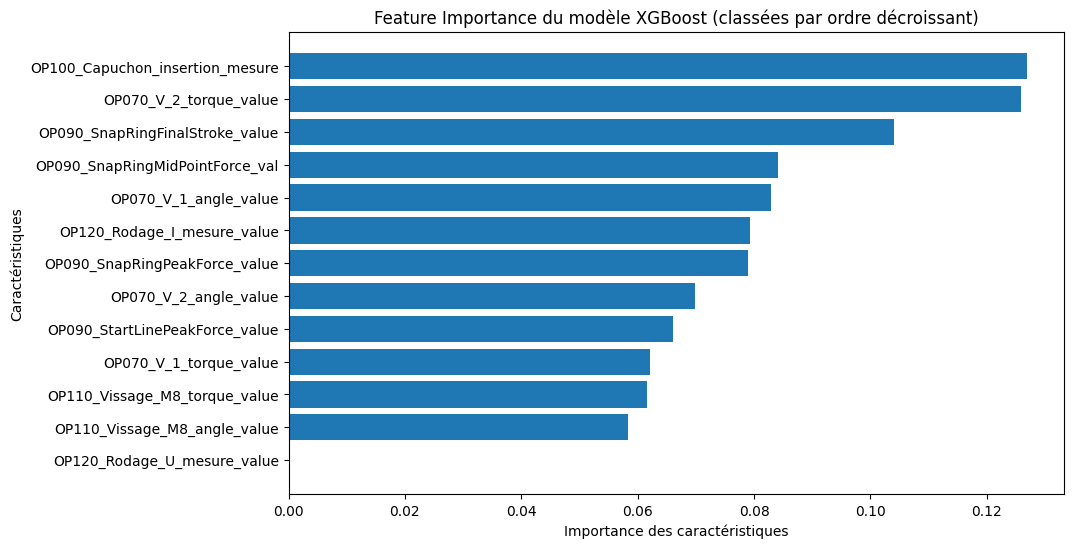

In [68]:
# Triez les importances des caractéristiques et les noms des caractéristiques par ordre décroissant
sorted_indices = feature_importance.argsort() # obtenir les indices des éléments par ordre croissant 
sorted_feature_importance = feature_importance[sorted_indices] # classe en fonction de l odre croissant d avant 
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Affichez les importances des caractéristiques classées par ordre décroissant
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.title('Feature Importance du modèle XGBoost (classées par ordre décroissant)')
plt.show()

Surprenant de voir  que la variable qui a le plus d'importance est celle qui regroupe les valeurs manquantes de notre dataset a hauteur de 51%

##### Option 2 : Recherche aléatoire (avec RandomizedSearchCV) - Best_score 0.678

Randomized Search sélectionne aléatoirement un nombre spécifié de combinaisons d'hyperparamètres à partir de l'espace d'hyperparamètres. Il effectue une recherche aléatoire parmi un sous-ensemble d'hyperparamètres, ce qui peut être plus efficace que Grid Search en termes de temps de calcul.

L'approche est de définir un nombre fixe de combinaison a tester , RandomizedSearchCV selectionne aléatoirement les valeurs pour chaque hyperparamètre a chaque itération. Cette approche a plusieurs avantanges : 

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [70]:
search_space_2 = { #définition de l espace de recherche  
    'max_depth': range(3, 10),
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'n_estimators': range(50, 250),
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'min_child_weight': range(1, 10),
    'gamma': [0.05, 0.1, 0.2, 0.3, 0.4],
}


In [71]:
# Créer RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=search_space_2,
    n_iter=500,  # Nombre d'itérations d'optimisation
    cv=5,  # Nombre pour la validation croisée
    scoring='roc_auc',  # Métrique de performance (ROC AUC)
    verbose=1,  # Afficher des détails pendant la recherche
    n_jobs=-1,  # Utiliser tous les cœurs du CPU
    random_state=42,
)

# Exécuter la recherche d'hyperparamètres
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.8,
                                                             1.0],
                                        'gamma': [0.05, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.2, 0.3, 0.4, 0.5,
                                                          0.6],
                                        'max_depth': range(3, 10),
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': range(50, 250),
                                        'subsample': [0.5, 0.7, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [72]:
# Afficher les meilleurs hyperparamètres trouvés
best_params = random_search.best_params_
print("Meilleurs hyperparamètres:", best_params)
print("Best score = %.3f after %d runs" % (random_search.best_score_, random_search.n_iter))

Meilleurs hyperparamètres: {'subsample': 0.8, 'n_estimators': 98, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.5}
Best score = 0.676 after 500 runs


Best score = 0.679 after 7000 runs 42min Meilleurs hyperparamètres: {'subsample': 1.0, 'n_estimators': 68, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}


Best score = 0.678 after 1 000 runs - 3min50 to 6 min

Best score = 0.662 after 2 000 runs

Best score = 0.662 after 4 000 runs

Best score = 0.658 after 4 000 runs

Best score = 0.658 after 5 000 runs 23min

Best score = 0.681 after 10 000 runs


##### Option 3: Processus bayesien (avec BayesSearchCV) - Best_score: 0.66

L’idée  de l’optimisation bayésienne est de minimiser le nombre d’observations tout en convergeant rapidement vers la solution optimale. Concrétement l'algorithme déterminerait la prochaine configuration ayant le plus de potentiel à tester en fonction des résultats des itérations précédentes en s'appuyant sur un processus gaussien.

Pour cela, il convient de connaître trois principes fondamentaux:
- Le processus Gaussien : d’exploiter les observations connues pour en déduire des probabilités d’événement qui n’ont pas encore été observées. Pour cela, il convient de déterminer pour chaque valeur X la distribution de probabilité. Le processus n'est pas applicable a toutes les observations a cause des limites de capacités calculatoires.

- Déterminer les points à plus fort potentiel avec la fonction d’acquisition : gagner en connaissance sur le comportement de la fonction et donc choisir une zone de l’espace de recherche où l’inconnu est grand : c’est l’exploration. D’autre part, nous souhaitons trouver le point qui minimise/maximise notre fonction : c’est l’exploitation. Ce compromis entre exploration et exploitation est exprimé par une fonction d’acquisition

- La fonction d’acquisition : Deux raisons permettent à une configuration donnée d’augmenter son potentiel, soit être dans une région loin de toutes configurations testées précédemment ou être dans une région près d’une configuration performante. En combinant ces deux critères, l’optimisation bayésienne cherche à réduire l’incertitude en explorant les régions peu explorées tout en exploitant les régions près d’une configuration performante. C’est ce qu’on appelle une fonction d’acquisition

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from pprint import pprint

In [74]:
# Define search space
search_space_3 = {
     'learning_rate': np.arange(0.01, 1.0),
     'max_depth': np.arange(2, 20),
     'reg_lambda': np.arange(1e-9, 100),
     'reg_alpha': np.arange(1e-9, 100),
     'gamma': np.arange(1e-9, 0.5),  
     'n_estimators': np.arange(10, 5000)
}

In [75]:
# Create Bayesian CV for HP optimization
bayes_cv = BayesSearchCV(
                    estimator = model,                                    
                    search_spaces = search_space_3,                      
                    scoring = 'roc_auc',                                  
                    cv = 5,                                   
                    n_iter = 50,                                      
                    n_points = 5,                                       
                    n_jobs = -1,                                        
                    refit=False,
                    verbose = 1,
                    random_state=42
)        

In [76]:
# Run bayesian CV
%time bayes_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 3min 13s, sys: 1min, total: 4min 13s
Wall time: 2min 53s


BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster='gbtree',
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=True,
                                      eval_metric='auc', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=...
       5.6e+01, 5.7e+01, 5.8e+01, 5.9e+01, 6.0e+01, 6.1e+01, 6.2e+01,
       6.3e+01, 6.4e+01, 6.5e+01, 6.6e+01, 6.7e+01, 6.8e+01, 6.9e+01,
       7.0e+01, 7.1e+01, 7.2e+01, 7.3e+01, 7.4e+01, 7.5e+01, 7.6e+01,
       7.7e+01, 7.8e+01, 7.9e+01, 8.0e+01, 8.1e+01, 8.2e+01, 8.3e+01,
       8.4e+01, 8.5e+01, 8.6e+01, 8.7e+01, 8.8e+01, 8.9e+01, 9.0e+01,
       9.1e+01, 9.2e+01, 9.3e+01, 9.4e+01, 9.5e+01, 9.6e+01, 9.7e+01,
       9.8e+01, 9.9e+01])},
              verbose=1)

In [77]:
# Show best params
print('Best parameters:')
print("Best score = %.3f after %d runs" % (bayes_cv.best_score_, bayes_cv.n_iter))

Best parameters:
Best score = 0.667 after 50 runs


Plusieurs nombres d'itérations ont été testés avec les résultats suivant: 
- Best score = 0.630 after 20 runs
- Best score = 0.626 after 30 runs
- Best score = 0.667 after 50 runs - 3min
- Best score = 0.668 after 100 runs - 7min 
- Best score = 0.638 after 300 runs - 35min 27s

##### Option 4: Approche 'HalvingGridSearchCV' - Best_score : 0.6631
Cette technique permet d'explorer le champs des possibles sans forcément trouver la combinaison optimale. L'avantage que présente cette méthode est de pouvoir maitriser le temps de calcul. L'idée est de chercher des paramètres sur des échantillons de plus en plus important en écartant a chaque itération la moitiée des combinaisons les moins performantes.

Deux options : choisir des valeurs ou utiliser des distributionse en utilisant une distribution uniforme, normale ou log-uniforme pour définir les plages de valeurs possibles des hyperparamètres. Cela permet d'explorer un espace plus large de manière plus efficace

In [78]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV 

In [79]:
counts = y_train.value_counts()
scale_pos_weight = counts[1] / counts[0]
scale_pos_weight

0.008915521777258111

In [80]:
search_space_4 = {
    "max_depth": [3, 4, 5],
    "gamma": [5, 30, 50],
    "learning_rate": [ 0.7,0.6],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

In [81]:
halving_grid = HalvingGridSearchCV(model,
                           param_grid= search_space_4, 
                           cv=5, 
                           scoring='roc_auc',
                           n_jobs=-1, 
                           random_state=42,
                           verbose=1)

In [82]:
# Exécuter la recherche d'hyperparamètres
halving_grid.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1278
max_resources_: 34515
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 1278
Fitting 5 folds for each of 54 candidates, totalling 270 fits


----------
iter: 1
n_candidates: 18
n_resources: 3834
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 11502
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 34506
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric='auc',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...),
                    n_jobs=-1,
                    param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                                'gamma': [5, 30, 50],
                                'learning_rate': [0.7, 0.6],
                                'max_depth': [3, 4, 5]},
                    random_state=42, scoring='roc_auc', verbose=1)

In [83]:
print(halving_grid.best_score_)
print(halving_grid.best_params_)

0.6631554980347043
{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.6, 'max_depth': 5}


0.6631554980347043

##### Option 5: Approche 'HalvingRandomSearchCV' - Best_score : 0.67

In [84]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from imblearn.under_sampling import RandomUnderSampler #gere les NA

In [85]:
search_space_5 = { #définition de l espace de recherche  
    'max_depth': range(3, 10),
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'n_estimators': range(50, 200),
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'min_child_weight': range(1, 10),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
}

In [86]:
HalvingRandomSearchCV0 = HalvingRandomSearchCV(
    model,
    param_distributions=search_space_5,
    n_candidates=500,  # Nombre de candidats à évaluer
    factor=3,         # Facteur de réduction : proportion of candidates that are selected for each subsequent iteration
    scoring='roc_auc',
    random_state=42,
    cv=5  # Nombre de plis pour la validation croisée
)

In [87]:
# Exécuter la recherche d'hyperparamètres
HalvingRandomSearchCV0.fit(X_train_RandomUnderSampler, y_train_RandomUnderSampler)

HalvingRandomSearchCV(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_ra...
                                              num_parallel_tree=None,
                                              random_state=None, ...),
                      n_candidates=500,
                      param_distributions={'colsample_bytree': [0.5, 0.7, 0.8,
                                                                1.0],
                                           'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                           'learning_rate': [0.01, 0.02, 0.05,
                                                             0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6],
                                           'max_depth': range(3, 10),
                                           'min_child_weight': range(1, 10),
                                           'n_estimators': range(50, 200),
                                           'subsample': [0.5, 0.7, 0.8, 1.0]},
                      random_state=42, scoring='roc_auc')

In [88]:
print(HalvingRandomSearchCV0.best_score_)
print(HalvingRandomSearchCV0.best_params_)

0.6423804609563124
{'subsample': 0.5, 'n_estimators': 146, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.02, 'gamma': 0.2, 'colsample_bytree': 1.0}


500 -> 0.67 -> 1 min 30 s

##### Option 6: Avec Hyperopt (Bayesian Optimization  ) - Best_score : 0.690

In [89]:
import hyperopt
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [90]:
hyperopt_space= {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.loguniform('gamma', -5, 0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

In [93]:
# Fonction objective pour l'optimisation
def objective(params): #fonction objective définite avec un seul paramètre : params
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        min_child_weight=int(params['min_child_weight']),
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        objective='binary:logistic',  # Pour une classification binaire
    )
    
    # Calcul de l'aire sous la courbe ROC (ROC AUC) à l'aide de la validation croisée
    auc_scores = cross_val_score(clf, X_train_del, y_train, cv=5, scoring='roc_auc')
    avg_auc = np.mean(auc_scores)
    return {'loss': -avg_auc, 'status': STATUS_OK}  # Hyperopt cherche à minimiser la fonction, nous utilisons donc le négatif de l'AUC

# Création d'un objet Trials pour suivre les itérations d'optimisation
# pour suivre et enregistrer les résultats de chaque évaluation d'hyperparamètres lors de la recherche d'hyperparamètres
# il conserve des informations sur chaque essai (trial) effectué lors de la recherche d'hyperparamètres
trials = Trials()

# Optimisation des hyperparamètres avec Hyperopt
best = fmin(fn=objective, 
            space= hyperopt_space, 
            algo=tpe.suggest, 
            max_evals=300, 
            trials=trials)

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :")
print(best)

100%|██████████| 300/300 [03:15<00:00,  1.54trial/s, best loss: -0.6711229100876458]
Meilleurs hyperparamètres :
{'colsample_bytree': 0.5140815004502373, 'gamma': 0.6162608986105302, 'learning_rate': 0.016774998537094493, 'max_depth': 9.0, 'min_child_weight': 10.0, 'n_estimators': 165.0, 'subsample': 0.7813141390960441}


##### Option 7 : Optuna - Best score : 0.689

XGBoost allows us to specify class weights, which adjust the importance of each class during training. By increasing the weight of the minority class, we can give it more influence on the model’s predictions. We can either specify the class weights manually or use the “scale_pos_weight” parameter, which is calculated automatically based on the class balance.


In [94]:
import optuna
import warnings
warnings.filterwarnings('ignore')
from optuna import Trial, create_study, study

Dataset disponibles :
- X_train : avec valeurs Nan , sans transformation (Hyperplot+300 -> 0.677)
- X_train_forest_imputed : Nan imputés avec Forest (Hyperplot+300 -> 0.673)
- X__Mice_imputed : Nan imputés avec Mice  (Hyperplot+300 -> 0.672)
- X_poly_2_No_nan : Nan imputés avec Forest + polynomes et interractions  (Hyperplot+300 -> 0.657)
- X_train_RandomUnderSampler , y_train_RandomUnderSampler : données parfaitement équilibrées mais moins importantes. (Hyperplot+300 -> 0.65) 
- X_train_del : imputation will bring a lot of noise (Hyperplot+300 -> 0.672, 1000 -> 0.673)
- X_train_poly2_outnan : polynomes sans OP100 (nan values) (Hyperplot+300 -> 0.657)

Les tests nous montrent que quelque soit la méthode d'imputation retenue , il y a perte de performances. Ceci est très probablement du  au fait que la création de bruit par les méthodes d'imputation.

In [ ]:
# Définition de la fonction objectif pour Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    clf = xgb.XGBClassifier(**params, 
                            n_jobs = -1, 
                            booster = 'gbtree', 
                            objective='binary:logistic', 
                            use_label_encoder=False,
                            #scale_pos_weight= 0.9911/0.0088 dégradation des résultats.
                            )
    # Évaluation à l'aide de la validation croisée avec ROC AUC comme métrique
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Affichage des meilleurs hyperparamètres et de la meilleure ROC AUC moyenne
best_params = study.best_params
best_auc = study.best_value


print("Meilleurs hyperparamètres :")
print(best_params)
print("Meilleure ROC AUC moyenne :", best_auc)

In [109]:
print("Meilleurs hyperparamètres :")
print(best_params)
print("Meilleure ROC AUC moyenne :", best_auc)

Meilleurs hyperparamètres :
{'n_estimators': 696, 'max_depth': 5, 'learning_rate': 0.004859991693380064, 'subsample': 0.5340219005049106, 'min_child_weight': 8, 'gamma': 3.755351162989106e-05, 'colsample_bytree': 0.5927568219679726}
Meilleure ROC AUC moyenne : 0.6765587188100497


100 - 3 min -Meilleure ROC AUC moyenne : 0.6801623051451737

500 - 12 min - Meilleure ROC AUC moyenne : 0.6815158064222425

1000 - Meilleure ROC AUC moyenne : 0.680

Progression des résultats de recherches des hyperparamètres avec itérations

In [97]:
optuna.visualization.plot_optimization_history(study)

In [98]:
#save best model
optuna_best_model_selec = xgb.XGBClassifier(**study.best_params)

In [99]:
optuna_best_model_selec.fit(X_train, y_train)
fe_importance_optuna = optuna_best_model_selec.feature_importances_
fe_importance_optuna

array([0.05927114, 0.06592327, 0.06168526, 0.06481956, 0.10556069,
       0.07066386, 0.13258067, 0.0214888 , 0.08920019, 0.08579316,
       0.06530517, 0.06903475, 0.10867345], dtype=float32)

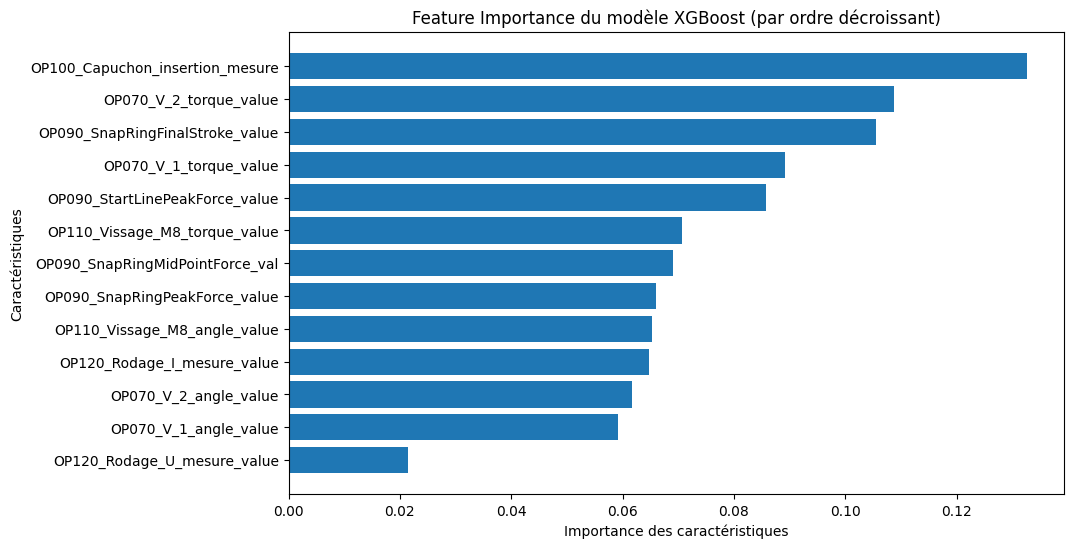

In [100]:
feature_names = X_train.columns

# Triez les importances des caractéristiques et les noms des caractéristiques par ordre décroissant
sorted_indices = fe_importance_optuna.argsort() # obtenir les indices des éléments par ordre croissant 
sorted_feature_importance = fe_importance_optuna[sorted_indices] # classe en fonction de l odre croissant d avant 
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Affichez les importances des caractéristiques classées par ordre décroissant
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.title('Feature Importance du modèle XGBoost (par ordre décroissant)')
plt.show()

In [101]:
optuna.visualization.plot_param_importances(study)

Various HPs tuned against the objective value they returned:
Les divers hyperparamètres tunés, le score obtenu et le nombre d'essais ayant produit le résultat.

In [108]:
optuna.visualization.plot_slice(study)


![Various HPs tuned.png](<attachment:Various HPs tuned.png>)
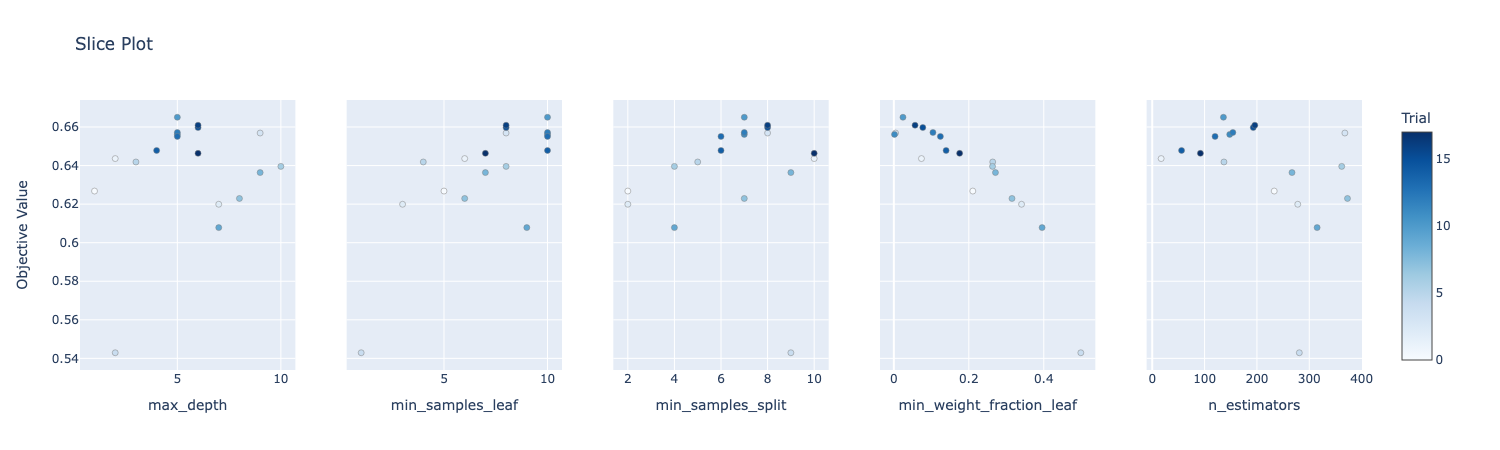

In [103]:
#Focal sur le learning rate : 
optuna.visualization.plot_slice(study, ['learning_rate'])

![Focal learning rate.png](<attachment:Focal learning rate.png>)
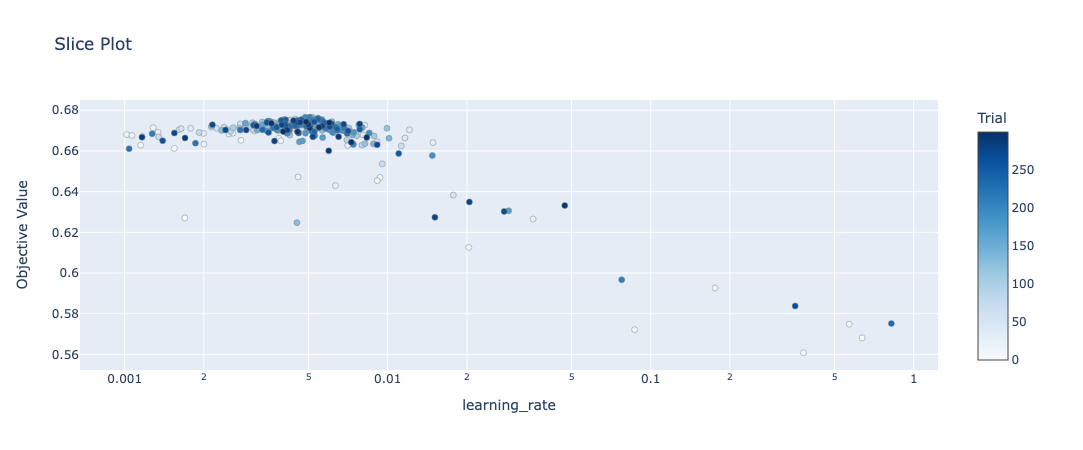

Visualisons la recherche du learning rate en fonction du colsample_bytree pour voir l'étendu des recherches faites par Optuna: 

In [104]:
optuna.visualization.plot_contour(study, ['learning_rate', 'colsample_bytree'])

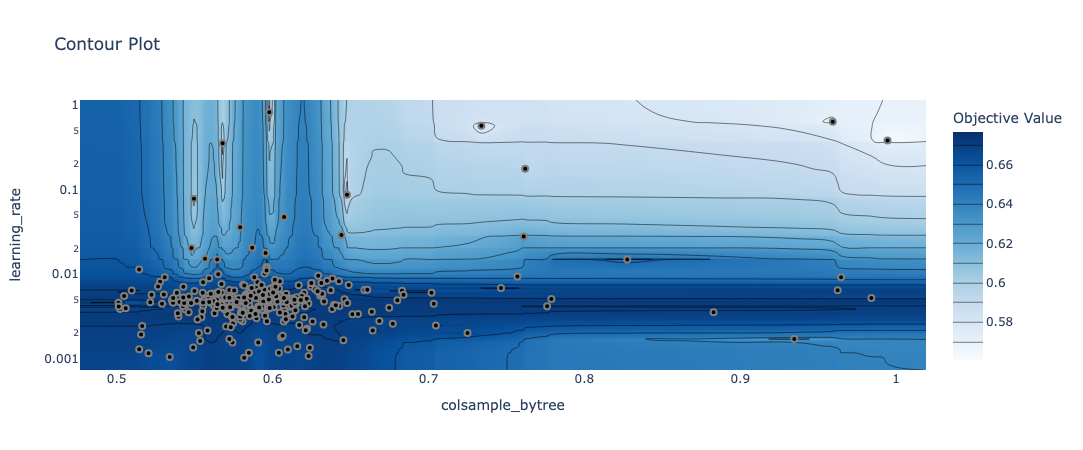


Chercher le bon learning rate revient a chercher une aiguille dans une botte de foin...

Deux conclusions : 
- augmenter dans la grille de recherche des hyperparamètres le nombre de valeurs possible du learning_rate peut nous faire gagner en performances.
- 3 variables (OP100, OP070, OP090) ont une importance relativement significative dans notre modèle. Il serait pertinant d'étudier leurs intéractions.
